# Forecasting

In this notebook we train our models to perform and evaluate bixi usage forecasts.

Model tuning and performance assesment is done via a cross-validation procedue using a seasonal time-series split on the training data. After the tuning is complete, we evaluate final model performance by performing a forecast on the test data.

Required imports:

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Validation
from lib import validation as val

# Imports required for particular models are done in their respective sections

In [211]:
import warnings
warnings.filterwarnings('ignore')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mont-Royal trip history data.

In [2]:
station_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('D')
display(station_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


### Split the Data

Split the data into training and test sets.
* Training set: from 2014 to 2018 (inclusive)
* Test set: 2019

Since the main low-frequency data periodicity is yearly, it makes sense to do a yearly split. This split gives approximately a 5 to 1 training to test split ratio (about 83:17).

**Notes**: 
* 2020 was excluded due to overall trend dip because of the pandemic, as can be seen in the visualization notebook.
* 2019 is missing the data for November so using it as test data will lead to large errors for November. We might want to exlude November from the test error calculations,

In [138]:
# Split station data into training and test set
demand_train = station_bike_demand['2014':'2018']
demand_test  = station_bike_demand['2019':'2019']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-14', freq='D'), columns=['trip_count'])
df['trip_count'] = 0
demand_train = pd.concat([df, demand_train])

# Exclude November data from the test set
demand_test  = demand_test[:'2019-10-31']

**Note**: there is one extra day in 2016 (leap year). Removing it seems to break the proper data frequency and letting it be shifts all periods by one. For now we leave it as it is, since a one day shift during a 0 usage period should not make a significant impact.

In [139]:
# Define validation and test parameters

# Configure the seasonal period to be yearly
seasonal_period = 365
# Configure test forecasting horizon to exclude November
test_fh = np.arange(1, 304+1)

# Dummy Baselines

## Seasonal Naive Baseline 

We will use Seasonal Naive model from the **sktime** library as our dummy baseline in two configurations:
* *last* - use the last year data as the prediction for the next.
* *mean* - use the mean data of all previous years as the prediction for the next.

Imports:

In [5]:
from sktime.forecasting.naive import NaiveForecaster

### Cross Validation

Use time-series split to perform cross-validation.

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,0.140827,44.656620,trip_count 2015-01-01 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2015-01-01 0 ...
1,0.161918,45.356276,trip_count 2016-01-01 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2016-01-01 0 ...
2,0.154238,43.119490,trip_count 2016-12-31 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2016-12-31 0 ...
3,0.187390,47.537066,trip_count 2017-12-31 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2017-12-31 0 ...


MeanAbsolutePercentageError     0.161094
MeanSquaredError               45.167363
dtype: float64

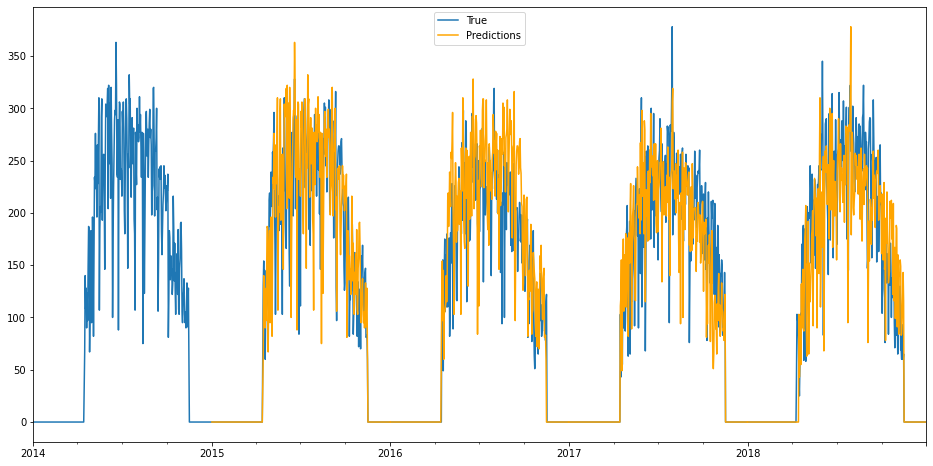

In [6]:
# Perform CV using the last strategy
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,0.140827,44.656620,trip_count 2015-01-01 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2015-01-01 0 ...
1,0.151474,42.301656,trip_count 2016-01-01 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2016-01-01 0 ...
2,0.144345,42.216305,trip_count 2016-12-31 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2016-12-31 0 ...
3,0.145354,36.941543,trip_count 2017-12-31 0.0 ...,trip_count 2014-01-01 0 ...,trip_count 2017-12-31 0 ...


MeanAbsolutePercentageError     0.145500
MeanSquaredError               41.529031
dtype: float64

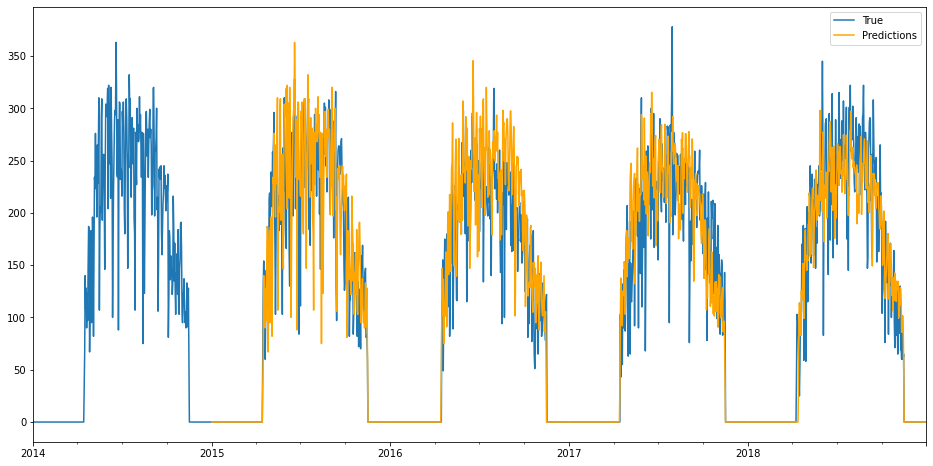

In [7]:
# Perform CV using the mean strategy
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

### Test Validation

MeanAbsolutePercentageError: 0.18295080249755327
MeanSquaredError: 46.55599345214093


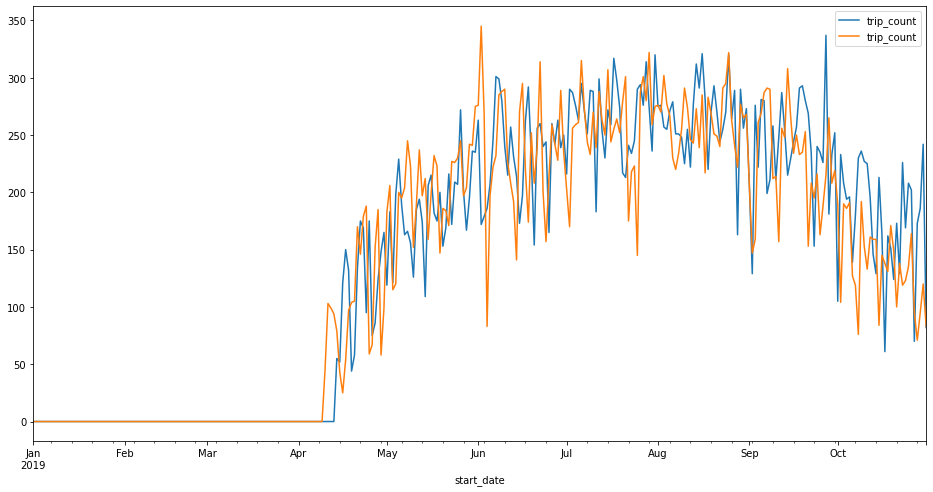

In [8]:
# Forecast using the seasonal naive random walk forecast
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

MeanAbsolutePercentageError: 0.16610885496437608
MeanSquaredError: 40.68761449979847


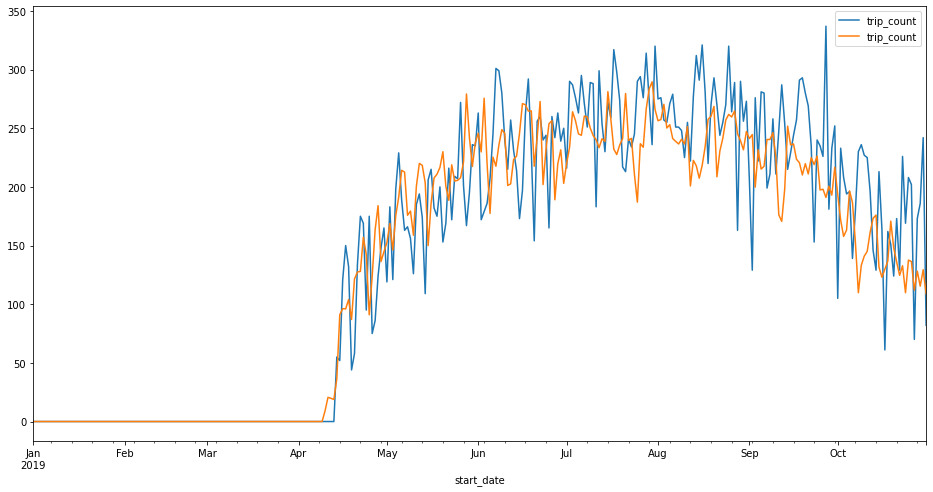

In [9]:
# Forecast using the seasonal naive mean forecast
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate and plot the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

# Facebook Prophet

Basic Facebook Prophet baseline.

**Note**: needs some tuning to perform well.

Required imports:

In [129]:
from sktime.forecasting.fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [14]:
# Convert the training DF to a Series
y = demand_train['trip_count']

# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

### Cross Validation

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,0.926428,33.846057,ds 2015-01-01 11.530811 2015-01-02 6.92...,2014-01-01 0 2014-01-02 0 2014-01-03 ...,2015-01-01 0 2015-01-02 0 2015-01-03 ...
1,0.943044,35.401585,ds 2016-01-01 -4.323931 2016-01-02 -12.53...,2014-01-01 0 2014-01-02 0 2014-01-03 ...,2016-01-01 0 2016-01-02 0 2016-01-03 ...
2,0.971210,42.220757,ds 2016-12-31 -21.641640 2017-01-01 -44.66...,2014-01-01 0 2014-01-02 0 2014-01-03 ...,2016-12-31 0 2017-01-01 0 2017-01-02 ...
3,0.908624,32.522046,ds 2017-12-31 -11.197525 2018-01-01 -13.91...,2014-01-01 0 2014-01-02 0 2014-01-03 ...,2017-12-31 0 2018-01-01 0 2018-01-02 ...


MeanAbsolutePercentageError     0.937327
MeanSquaredError               35.997611
dtype: float64

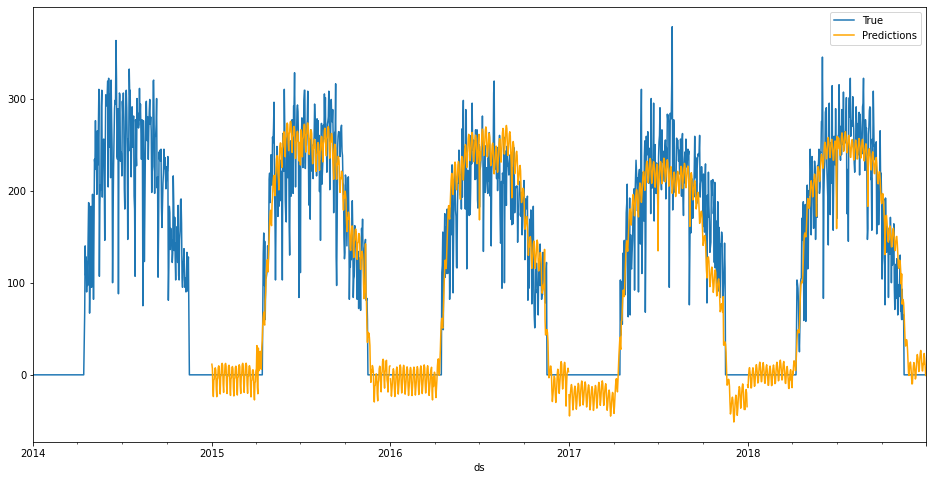

In [15]:
# Perform CV using the mean strategy
results = val.evaluate_cv(forecaster, y, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

### Test Validation

In [16]:
# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

# Train the model
forecaster.fit(y)

Prophet(add_country_holidays={'country_name': 'Canada'},
        daily_seasonality=False, yearly_seasonality=True)

MeanAbsolutePercentageError: 0.7908058878781813
MeanSquaredError: 33.71505595078879


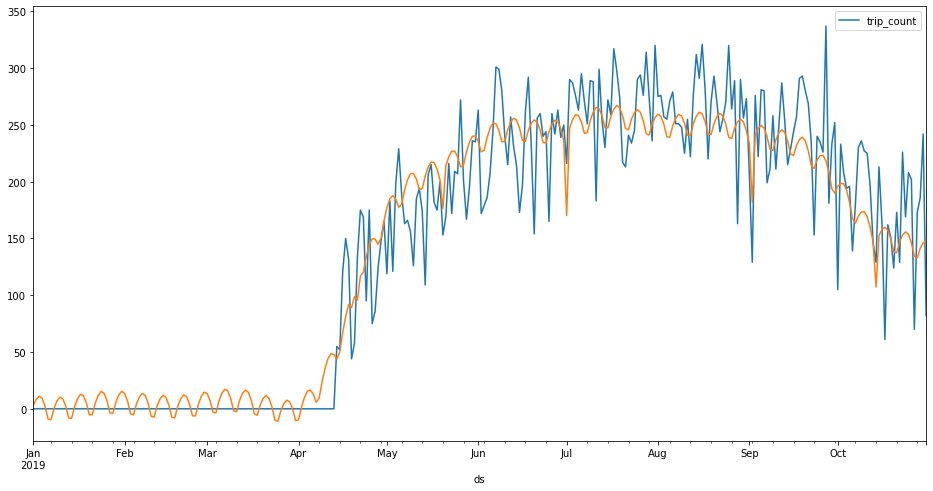

In [17]:
# Evaluate and plot the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

# Seasonal ARIMA

Basic seasonal ARIMA model.

Required imports

In [32]:
from time import time
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

#### Time frame

Selecting data from the opening in 2014 to the end of 2019

In [22]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2019, 10, 31)
lim_station_bike_demand = station_bike_demand[start_date:end_date]

#### Plotting data

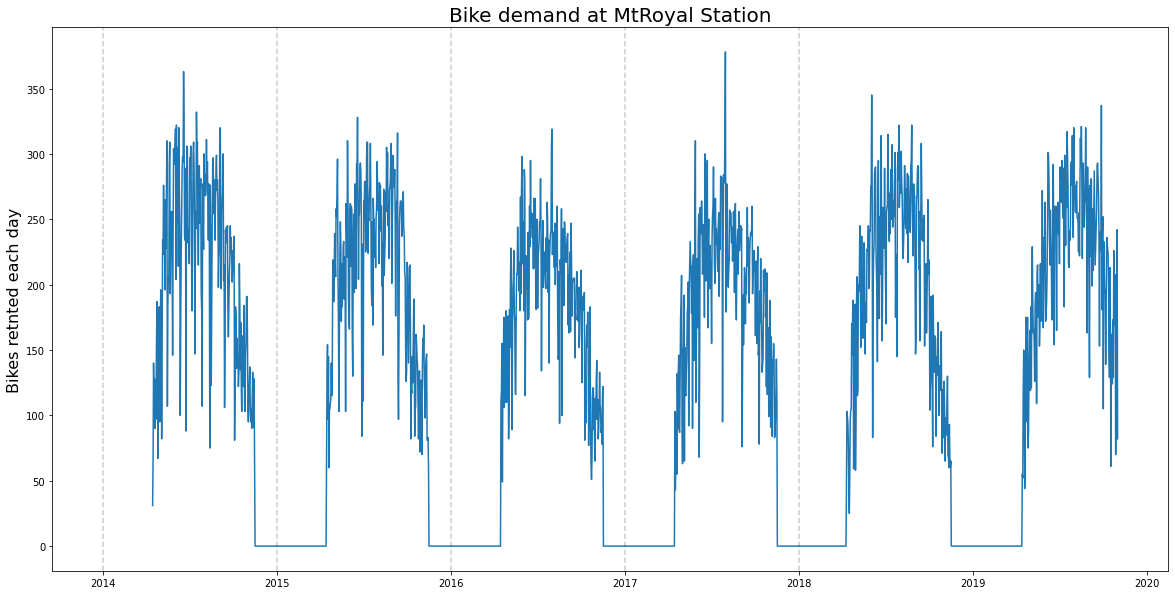

In [23]:
plt.figure(figsize=(20,10))
plt.plot(lim_station_bike_demand)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes retnted each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#### Removing trend

In [24]:
first_diff = lim_station_bike_demand.diff()[1:]

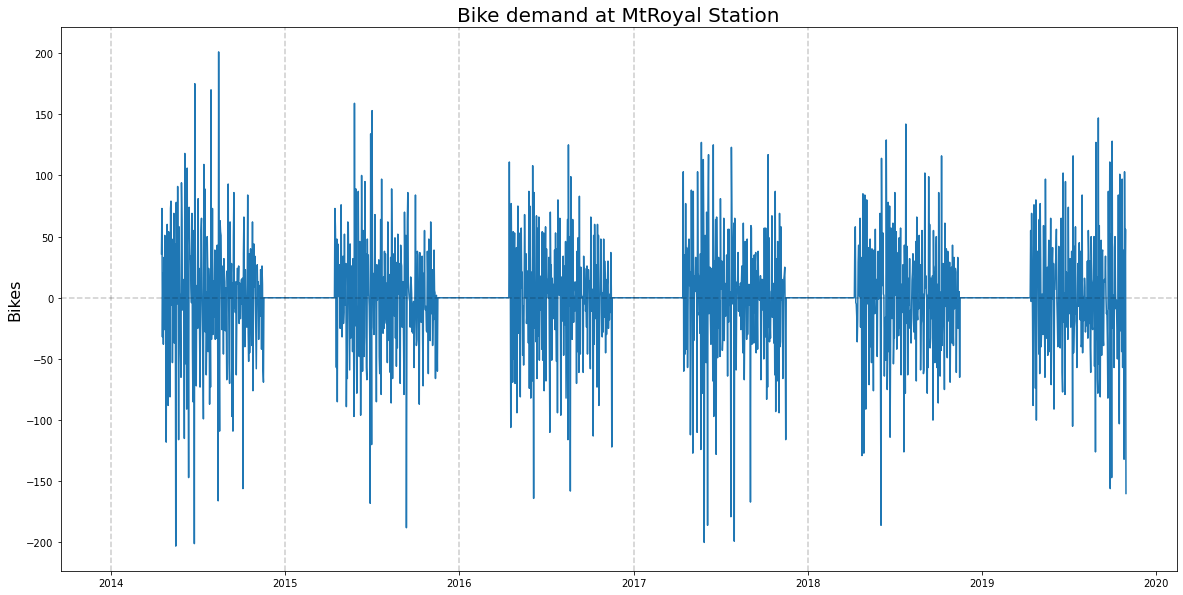

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(first_diff)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2);

#### ACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


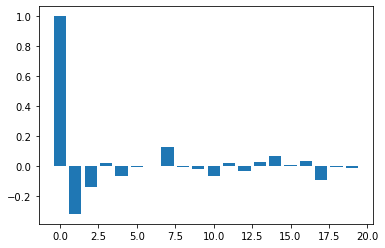

In [26]:
acf_vals = acf(first_diff, fft = False)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags]);

#### PACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1022: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


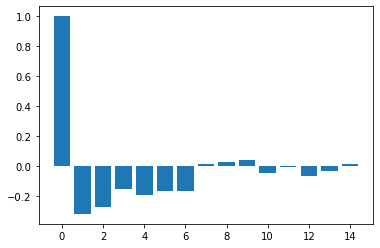

In [27]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags]);

#### Setting training and testing sets

In [28]:
# Train Data
train_end = datetime(2018, 11, 15)
train_data = lim_station_bike_demand[:train_end]

# Test Data
test_begin = datetime(2019, 4, 14)
test_end = datetime(2019, 10, 31)
test_data = lim_station_bike_demand[test_begin:test_end]

### Fitting Seasonal ARIMA Model

In [29]:
# SARIMA PARAMETERS:

my_order = (0, 0, 0)
my_seasonal_order = (1, 0, 0, 365)

In [30]:
# Defining model

model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

In [33]:
# Fit the model

start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 102.65926623344421


In [34]:
# Summary of the model

print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:                trip_count   No. Observations:                 1676
Model:             SARIMAX(1, 0, 0, 365)   Log Likelihood               -9302.266
Date:                   Tue, 30 Nov 2021   AIC                          18608.532
Time:                           11:46:50   BIC                          18619.380
Sample:                       04-15-2014   HQIC                         18612.551
                            - 11-15-2018                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L365      0.9598      0.003    294.872      0.000       0.953       0.966
sigma2      2228.7536     60.756     36.684      0.000    2109.674    2347.834
Ljung-Box (L1) (Q):         

In [35]:
# Get predictions and residuals

predictions = model_fit.forecast('2019-10-31')

print("len(test_data)): "+str(len(test_data)))
print("len(test_data.index): "+str(len(test_data.index)))

predictions = pd.Series(predictions, index=test_data.index)
display(predictions)

len(test_data)): 201
len(test_data.index): 201


start_date
2019-04-14     75.825606
2019-04-15     41.272165
2019-04-16     23.995445
2019-04-17     51.830161
2019-04-18     93.102326
                 ...    
2019-10-27     91.182691
2019-10-28     68.147064
2019-10-29     91.182691
2019-10-30    115.178136
2019-10-31     79.664877
Freq: D, Name: predicted_mean, Length: 201, dtype: float64

#### Getting residuals

In [36]:
residuals = test_data['trip_count'] - predictions
display(residuals)

start_date
2019-04-14    -20.825606
2019-04-15     10.727835
2019-04-16     97.004555
2019-04-17     98.169839
2019-04-18     38.897674
                 ...    
2019-10-27    -21.182691
2019-10-28    104.852936
2019-10-29     94.817309
2019-10-30    126.821864
2019-10-31      2.335123
Freq: D, Length: 201, dtype: float64

#### Plotting predictions

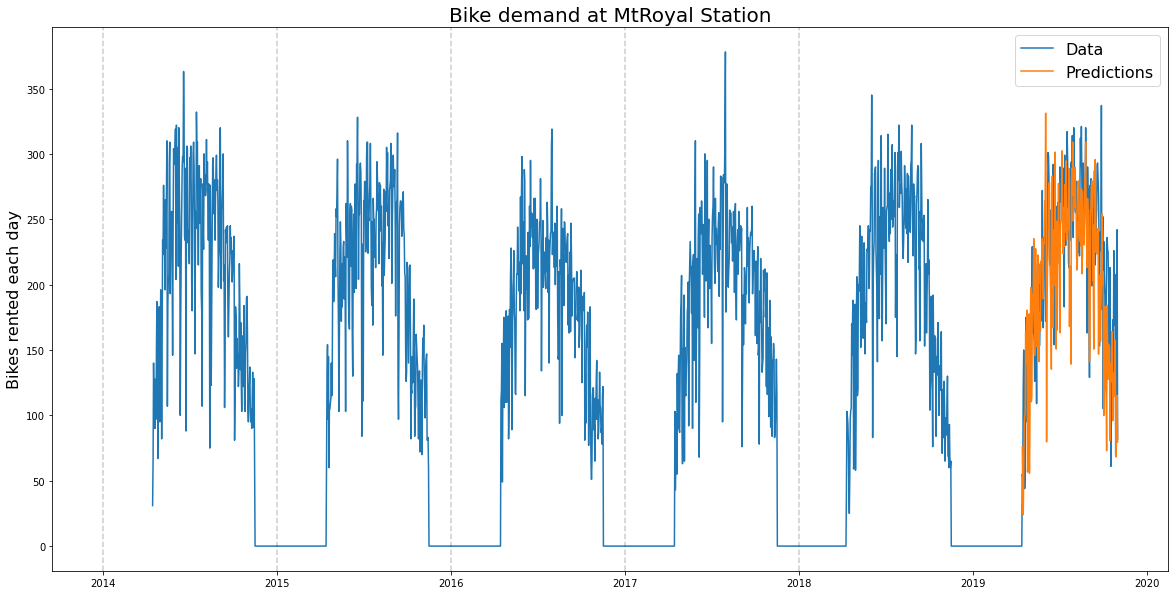

In [37]:
plt.figure(figsize=(20, 10))

plt.plot(lim_station_bike_demand)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes rented each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#### Evaluate Model

In [48]:
def get_mse(residuals):
    mse = 0
    for residual in residuals:
        mse+= residual**2
    return mse/(len(residuals))

def get_mape(predictions, residuals, test_data):
    result = 0
    percentage = 1/len(predictions)
    for i in range(0, len(test_data['trip_count'])):
        result+= (abs(residuals[i])/test_data['trip_count'][i])*percentage
    return result

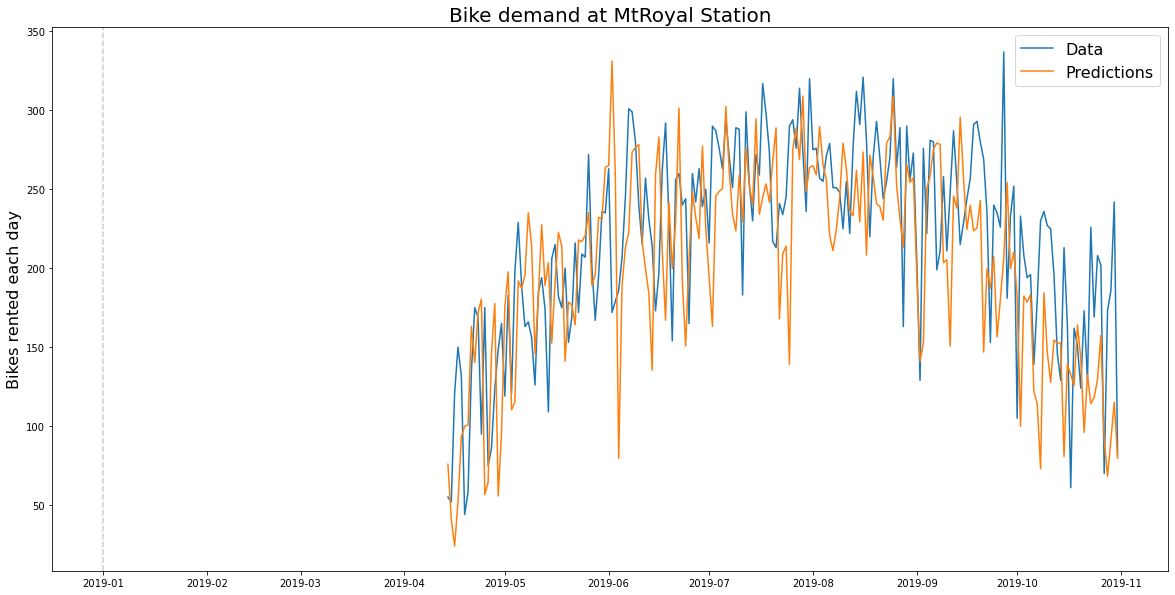

In [49]:
plt.figure(figsize=(20, 10))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes rented each day', fontsize=16)
plt.axvline(pd.to_datetime(str(2019)+'-01-01'), color='k', linestyle='--', alpha=0.2);

In [50]:
print("mse: "+str(get_mse(residuals)))
print("mape: "+str(get_mape (predictions, residuals, test_data)))

mse: 3190.3724622391223
mape: 0.23200699900201166


# AutoARIMA Baseline

Running with 7 day seasonality, auto-arima could not run fit() with 365 day

In [337]:
from sktime.forecasting.arima import AutoARIMA
fh = np.arange(1, len(demand_test)+1)
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(demand_train)


AutoARIMA(sp=7, suppress_warnings=True)

MeanAbsolutePercentageError: 1.392372504860266
MeanSquaredError: 135.34350819806224


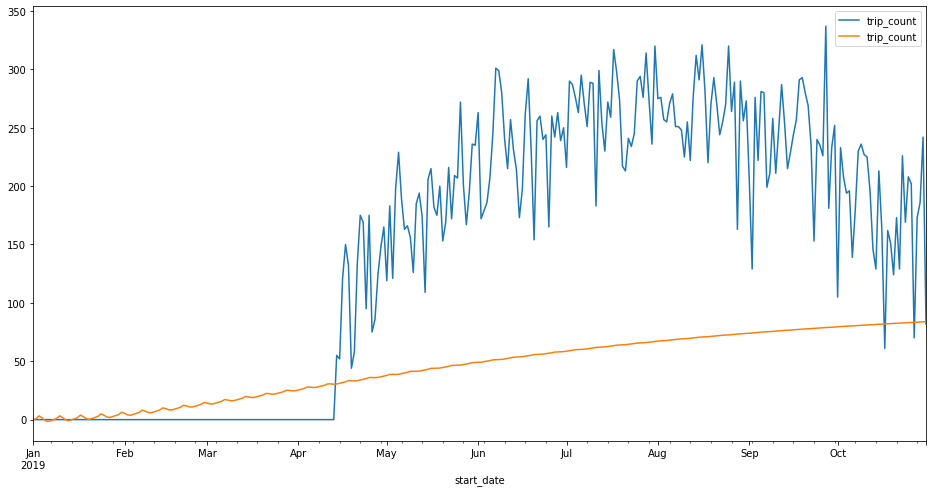

In [338]:
val.eval_forecast(forecaster, fh, demand_test)

# KNN Model

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor

MeanAbsolutePercentageError: 0.20864391997796403
MeanSquaredError: 51.623064510678596


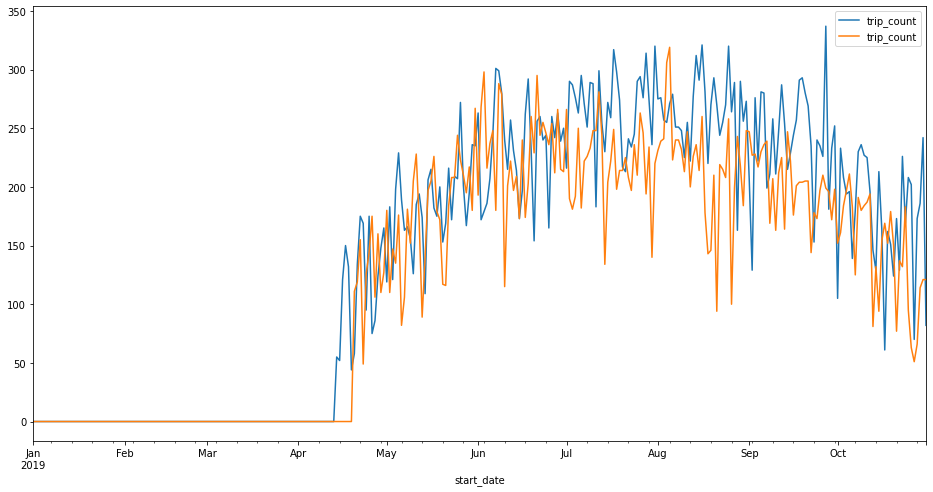

In [290]:
fh = np.arange(1, len(demand_test)+1)
knn = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=knn, window_length=365, strategy="recursive")
forecaster.fit(demand_train)
val.eval_forecast(forecaster, fh, demand_test)

# Forecasting at Weekly / Monthly Frequencies

1. Run Auto-Arima, KNN, and Prophet At the Weekly Level

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError

In [352]:
#Load data at a weekly frequency
y_weekly = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('W')

yw_train = y_weekly['2014-04-15':'2018']
yw_test  = y_weekly['2019':'2019-10-31']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-14', freq='W'), columns=['trip_count'])
df['trip_count'] = 0
yw_train = pd.concat([df, yw_train])
fh = np.arange(1, len(yw_test)+1)

In [353]:
#Define forecasters and run training
forecasters = dict()
forecasters['auto_arima'] = AutoARIMA(sp=1, suppress_warnings=True)
forecasters['knn'] = make_reduction(estimator=KNeighborsRegressor(n_neighbors=1), window_length=52, strategy="recursive")
forecasters['prophet'] =  Prophet(
                            seasonality_mode='additive',
                            n_changepoints=25, # default
                            add_country_holidays={'country_name': 'Canada'},
                            daily_seasonality=False,
                            weekly_seasonality=True,
                            yearly_seasonality=True)

results = dict()
results["y_test"] = yw_test['2019-04':]
for key, forecaster in forecasters.items():
    if key == 'prophet':
        forecaster.fit(yw_train['trip_count'])
    else:
        forecaster.fit(yw_train)
    results[key] = forecaster.predict(fh)
    results[key] = results[key]['2019-04':] #reduce fh to only the operating period


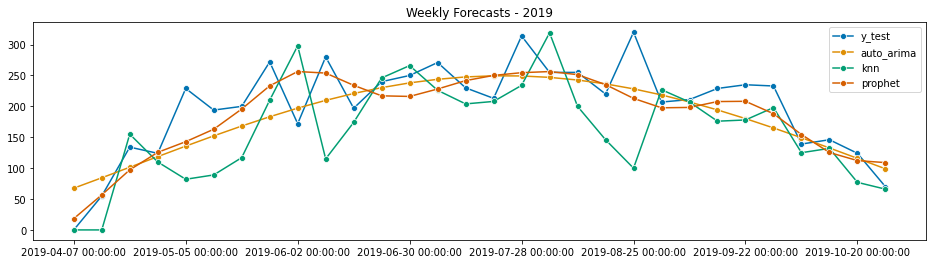

In [358]:
x_ticks = [y.to_pydatetime().strftime("%m-%d") for y in yw_test.index]
plot_series(*list(results.values()), labels=list(results.keys()))
plt.title("Weekly Forecasts - 2019");


In [355]:
for key, forecaster in forecasters.items():
    print(key)
    print('  MAPE: ', MeanAbsolutePercentageError(multioutput='uniform_average')(results['y_test'], results[key]))
    print('  MSE: ', MeanSquaredError(multioutput='uniform_average',square_root=True)(results['y_test'], results[key]))

auto_arima
  MAPE:  0.23863025103973307
  MSE:  43.91679962824742
knn
  MAPE:  0.34645718922187174
  MSE:  75.58438992278762
prophet
  MAPE:  0.2164952393632843
  MSE:  39.50118565604417


2. Run Auto-Arima, KNN, Auto-ETS, and Prophet At the Monthly Level

In [359]:
#Load data at a monthly frequency
y_monthly = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('M')

ym_train = y_monthly['2014-04-15':'2018']
ym_test  = y_monthly['2019':'2019-10-31']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-14', freq='M'), columns=['trip_count'])
df['trip_count'] = 0
ym_train = pd.concat([df, ym_train])
fh = np.arange(1, len(ym_test)+1)

In [360]:
#Define forecasters and run training
forecasters = dict()
forecasters['auto_arima'] = AutoARIMA(sp=12, suppress_warnings=True)
forecasters['knn'] = make_reduction(estimator=KNeighborsRegressor(n_neighbors=1), window_length=12, strategy="recursive")
forecasters['prophet'] =  Prophet(
                            seasonality_mode='additive',
                            n_changepoints=25, # default
                            add_country_holidays={'country_name': 'Canada'},
                            daily_seasonality=False,
                            yearly_seasonality=True)

results = dict()
results["y_test"] = ym_test['2019-04':]
for key, forecaster in forecasters.items():
    if key == 'prophet':
        forecaster.fit(ym_train['trip_count'])
    else:
        forecaster.fit(ym_train)
    results[key] = forecaster.predict(fh)
    results[key] = results[key]['2019-04':] #reduce fh to only the operating period


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


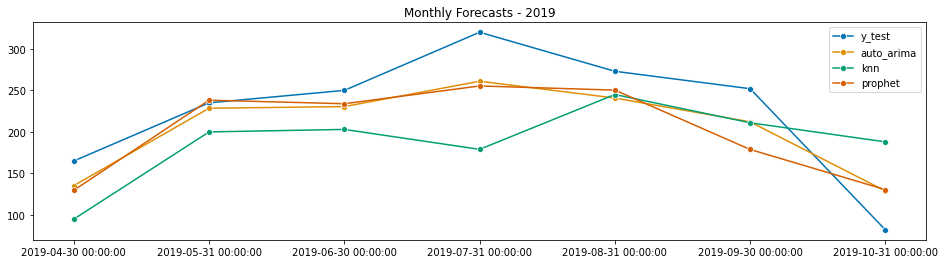

In [361]:
plot_series(*list(results.values()), labels=list(results.keys()))
plt.title("Monthly Forecasts - 2019");

In [362]:
for key, forecaster in forecasters.items():
    print(key)
    print('  MAPE: ', MeanAbsolutePercentageError(multioutput='uniform_average')(results['y_test'], results[key]))
    print('  MSE: ', MeanSquaredError(multioutput='uniform_average',square_root=True)(results['y_test'], results[key]))

auto_arima
  MAPE:  0.17875261642696527
  MSE:  37.041399654963506
knn
  MAPE:  0.36320228325757614
  MSE:  77.38216848861241
prophet
  MAPE:  0.2038389015557078
  MSE:  44.57952436934165
